#Indicadores de la privación

A los que leyeron la última entrada en el blog <a href="http://wp.me/p6LyTI-u">Privación en Inglaterra</a> se darán cuenta que esta es en un formato distinto. En este análisis, explicaré los métodos que usé para caragr los datos y convertirlos en un formato útil para hacer un análisis de regresión múltiple. No pudé encontrar ningunos módulos de Python que ayudan con la selección de los variables de la regresión y como tal escribí unos funciones para hacerlo. Si sabes algo que puedo hacer para mejorar mis métodos de análisis, dime en la sección de comentarios.

Este análisis se enfoca en el use de Python como una herramienta de análisis de los datos. Hice uso de los módulos de <a href="http://pandas.pydata.org/">Pandas</a> y <a href="http://www.numpy.org/">Numpy</a> para transformar los datos y los módulos de <a href="http://scikit-learn.org/stable/">Sklearn</a>, <a href="http://statsmodels.sourceforge.net/">Statsmodels</a> y <a href="http://www.scipy.org/">Scipy</a> para hacer la regresión.

Hice este análisis en un <a href="http://ipython.org/">iPython Notebook</a> que viene con <a href="https://www.continuum.io/downloads">Anaconda</a>, el fantástico producto de la computación científica. No me pagaron para decirlo.

La celda abajo coniente las declaraciones que importan los módulos que usaré. matplotlib.pyplot y seaborn son módulos de la visualización de los datos (no los usé mucho); numpy y pandas me permiten modificar, controlar y presentar los datos en bruto; sklearn, scipy y statsmodels son módulos de la estadística que hacen las partes mas complejas.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
from sklearn import linear_model, cross_validation
from scipy import stats
import statsmodels.api as sm
import itertools
import copy
%matplotlib inline

#Importar los Datos

Los datos que uso en este análisis viene en dos formatos, .csv y .xls. El módulo de pandas me permite cargar los datos y convertirlos en un 'DataFrame'. Un 'DataFrame' muestra los datos de forma tabular, pero no funciona como una hoja de cálculo; no se pueden editar las celdas directamente.

La celda a bajo carga un archivo de .csv, le convirte en un DataFrame (geo_df), tira la columna 'Unnamed: 0', y luego toma una copia de los datos (base) usando .loc[ : , : ] que previsualizo por escribir base.head()

Este DataFrame contiene los códigos de la geografía, hecho por el oficio de estadísticas nacionales. Se usan para delinear las areas geografícas de tamanos varios. La mayoría de los códigos empezaan con 'E' seguido por dos números. Cuanto menor sea el número, el más grande es la area geográfica que se representa. El código y los datos que usé para crear esta tabulación están en mi cuenta de <a href="https://github.com/richard-muir/ONS-Geo-Codes">GitHub</a>.

In [9]:
#LOADS AN ONS GEOGRAPHY CODES LOOKUP AND TAKES A COPY OF IT
geo = pd.read_csv("C:\\Users\\Rytch\\Google Drive\\Data Analysis\\Data\\ONS Geo Codes\\ONS Geo Lookup.csv", encoding = "ISO-8859-1", low_memory=False)
geo_df = DataFrame(geo)
geo_df.drop(['Unnamed: 0'], axis=1, inplace=True)
base = geo_df.loc[:,:]
base.head()

,OA,LSOA,MSOA,LAD,WARD,PARISH,GOR,GOR NAME,COUNTY,COUNTY CODE,COUNTY NAME,LAD CODE,AUTH/DIST/BORO NAME,WARD CODE
0,E00000001,E01000001,E02000001,E09000001,E05000001,NaN,H,London,NaN,0,Greater London,00AA,City of London,00AAFA
1,E00000003,E01000001,E02000001,E09000001,E05000001,NaN,H,London,NaN,0,Greater London,00AA,City of London,00AAFA
2,E00000005,E01000001,E02000001,E09000001,E05000001,NaN,H,London,NaN,0,Greater London,00AA,City of London,00AAFA
3,E00166756,E01000001,E02000001,E09000001,E05000001,NaN,H,London,NaN,0,Greater London,00AA,City of London,00AAFA
4,E00166758,E01000001,E02000001,E09000001,E05000001,NaN,H,London,NaN,0,Greater London,00AA,City of London,00AAFA


Después de investigar lor otros conjuntos de dato, descrubrí que la única código de área que todos tuvieron en común fue 'LAD' (Distrito de Área Local). Para claridad, tiré las otras columnas de este DataFrame.

In [10]:
#DROPS THE COLUMNS WHICH I CAN'T MERGE ON IN THE OTHER DATASETS
base_dep = base.drop(['OA','LSOA','MSOA','WARD','PARISH','GOR','GOR NAME','COUNTY','COUNTY CODE','COUNTY NAME','AUTH/DIST/BORO NAME'], axis=1, )
base_dep.drop_duplicates(subset=['LAD'], inplace=True)
base_dep.head()

,LAD,LAD CODE,WARD CODE
0,E09000001,00AA,00AAFA
36,E09000002,00AB,00ABFX
589,E09000003,00AC,00ACFX
1625,E09000004,00AD,00ADGA
2353,E09000005,00AE,00AEGJ


En una manera similar al archivo anterior que cargué, pandas carga al archivo Deprivation.xls y lo converite en un DataFrame. Cuando se carag un archivo .xls, hay que buscar a la hoja de cálculo de Excel que se necesita (aquí 'IMD 2010'). Para claridad  puse nuevo nombre a una columna y tiré la columna de 'Deprivation Rank' porque no sirve por nada en este análisis.

Después de prever el DataFrame, tomé nota que aunque el Código LAD está presente (LA CODE en los datos), hay multiples observaciones por cada LA Code. Las observaciones corresponden a cada única código LSOA, una área de geografía más pequeña. Es claro que el resultado de la privación varía dentro de un Código LA. Por ejemplo, el Código LA '00AA' tiene un mínimo de 5.6 y un máximo de 21.4.

Decidí tomar la media del reslutado de la privación de cada Código LA y aumentarla con la desviación estándar si tengo que tomar en cuenta la variación dentro de los Códigos LA (al final no fue necesario).

In [11]:
#LOADS A DEPRIVATION SCORE XLS FILE WHICH IS AVAILABLE ON THE ONS WEBSITE, RENAMES/DROPS A COUPLE OF COLUMNS
deprivation_xl = pd.ExcelFile('Deprivation.xls')
dep_df = deprivation_xl.parse('IMD 2010')
dep_df.rename(columns={'IMD SCORE':'DEPRIVATION SCORE'},inplace=True)
dep_df=DataFrame(dep_df)
dep_df.drop('RANK OF IMD SCORE (where 1 is most deprived)', 
            axis=1, inplace=True)
dep_df.head(10)




,LSOA CODE,LA CODE,LA NAME,GOR CODE,GOR NAME,DEPRIVATION SCORE
0,E01000001,00AA,City of London,H,London,6.161637
1,E01000002,00AA,City of London,H,London,5.585054
2,E01000003,00AA,City of London,H,London,13.292920
3,E01000004,00AA,City of London,H,London,11.171350
4,E01000005,00AA,City of London,H,London,21.364660
5,E01000006,00AB,Barking and Dagenham,H,London,17.077650
6,E01000007,00AB,Barking and Dagenham,H,London,37.235280
7,E01000008,00AB,Barking and Dagenham,H,London,45.216770
8,E01000009,00AB,Barking and Dagenham,H,London,29.413560
9,E01000010,00AB,Barking and Dagenham,H,London,38.447980


Usé funciones varias del módulo de pandas para create un DataFrame que tiene los valores únicos del Código LA - lo hice con pd.groupby, pero podría haber usado pd.unqiue. Después creé un DataFrame (mean_dep) que contiene la media del resultado de privación por cada Código LA, y también un otro con la desviación estándar. Luego los combiné con el Código LA como llave.

El DataFrame, 'deprivation_df' contiene la variable 'MEAN DEP SCORE' que usaré como variable de respuesta en etse análisis.

In [12]:
#CREATES A DATAFRAME CONTAINING ONLY UNIQUE VALUES OF 'LA CODE'
dep = dep_df.groupby('LA CODE')
#CALCULATES THE MEAN DEPRIVATION SCORE FOR EACH LA CODE BY TAKING THE MEAN OF THE DEPRIVATION SCORES OF THE LSOA CODES 
#WITHIN THAT LA
mean_dep = DataFrame(dep['DEPRIVATION SCORE'].mean())
#THE LA CODE WAS SET AS THE INDEX, THIS CHANGES IT TO BE A COLUMN
mean_dep['LA CODE'] = mean_dep.index
#RENAMES THE DEPRIVATION SCORE APPROPRIATES, RESETS THE INDEX
mean_dep.rename(columns={'DEPRIVATION SCORE':'MEAN DEP SCORE'}, inplace=True)
mean_dep.reset_index(drop=True,inplace=True)

#REPEATS THE ABOVE PROCESS, BUT FOR THE STANDARD DEVIATIO OD THE DEPRIVATION SCORE
std_dep = DataFrame(dep['DEPRIVATION SCORE'].std())
std_dep['LA CODE'] = std_dep.index
std_dep.rename(columns={'DEPRIVATION SCORE':'STD DEP SCORE'}, inplace=True)
std_dep.reset_index(drop=True, inplace=True)

#MERGES THE MEAN AND STD DEPRIVATION SCORES TOGETHER
deprivation_df = mean_dep.merge(std_dep, on='LA CODE')
deprivation_df.head()

,MEAN DEP SCORE,LA CODE,STD DEP SCORE
0,11.515124,00AA,6.405421
1,34.094765,00AB,8.255361
2,16.488612,00AC,8.427992
3,16.520170,00AD,10.268777
4,30.166109,00AE,11.454649


Luego, combiné 'deprivation_df' con el DataFrame que contiene los códigos de la geografía; las llaves se llaman en un amanbera distinto en los dos DataFrames y tomé cuenta de eso para usar 'left_on=' 7 'right_on=' en la lista de de argumentos de pd.merge. Si se usa un iPython Notebook, después de abrir los paréntesis, pulsa la tecla de mayúsculas + la tecla de tabulación para ver los argumentos y argumentos de palabra clave por la función.

In [13]:
#MERGES THE ONS BASE GEOGRAPHY DATAFRAME WITH THE DEPRIVATION; THIS FORMS THE INTIAL DATASET ONTO WHICH ALL THE 
#PREDICTORS OF DEPRIVATION WILL BE MERGED, EACH ON LA CODE, LAD OR WARD CODE
base_dep_df = deprivation_df.merge(base_dep, how='left', left_on='LA CODE', right_on='LAD CODE')
base_dep_df.head()

,MEAN DEP SCORE,LA CODE,STD DEP SCORE,LAD,LAD CODE,WARD CODE
0,11.515124,00AA,6.405421,E09000001,00AA,00AAFA
1,34.094765,00AB,8.255361,E09000002,00AB,00ABFX
2,16.488612,00AC,8.427992,E09000003,00AC,00ACFX
3,16.520170,00AD,10.268777,E09000004,00AD,00ADGA
4,30.166109,00AE,11.454649,E09000005,00AE,00AEGJ


Los datos que cargué en esta célula contiene información sobre la cantidad de gente de cada edad en cada área geográfica. Estos datos se cargó en la misma manera como los datos por 'deprivation_df', aunque tuve que hacer una función de pd.dropna() para eliminar las filas que contuvieron únicamente valores faltantes.

Los datos en este DataFrame no están en un formato agradable. Primero, hay mas de 100 columnas de datos, uno por la cantidad de gente de cada edad en cada área - este nivel de información es demasiado especifico para que pueda tomar conclusiones de el y tendré agregar los datos. Además, los Códigos de Área representan áreas geográficas de tamaño distinte; las filas no se comparan con los de arriba y abajo. Por ejemplo, la fila 3 (Código de Área K04) corresponde a la totalidad del Reino Unido mientrat la fila 7 (E12) se refiere al Noreste del país. Esto me cuesta mucho arrgelar como se va a ver...

In [14]:
#LOADS AN XLS FILE WHICH CONTAINS INFORMATION ABOUT THE AGE OF PEOPLE IN DIFFERENT GEOGRAPHICAL AREAS. AVAILABLE FROM ONS WEBSITE
#RENAMES AND DROPS COLUMNS, DROPS ALL NA TO TIDY UP
age_xl = pd.ExcelFile('Age.xls')
age_df = age_xl.parse('QS103EW_Numbers',header=10)
age_df = DataFrame(age_df)
age_df.drop(['Unnamed: 2','Unnamed: 3', 'Area name'],axis=1, inplace=True)
age_df.dropna(axis=0, inplace=True)
age_df.head(10)

,Area code,All categories: Age,Age under 1,Age 1,Age 2,Age 3,Age 4,Age 5,Age 6,Age 7,...,Age 91,Age 92,Age 93,Age 94,Age 95,Age 96,Age 97,Age 98,Age 99,Age 100 and over
3,K04000001,56075912,711529,704155,698777,699399,682890,666320,633615,627104,...,87515,52939,40013,36269,27972,22324,15959,10976,7145,11186
5,E92000001,53012456,675065,668662,663119,663574,648029,632090,600847,594673,...,82336,49584,37630,34145,26370,21040,15044,10327,6738,10576
7,E12000001,2596886,30606,30202,29686,29934,29415,29041,27545,27103,...,3717,2373,1732,1410,1120,841,601,410,323,456
9,E06000047,513242,5884,5645,5602,5826,5617,5366,5325,5127,...,709,461,331,262,215,187,144,87,76,80
10,E06000005,105564,1344,1371,1302,1297,1265,1289,1271,1230,...,148,104,91,69,50,34,26,32,22,28
11,E06000001,92028,1097,1176,1155,1159,1111,1150,1051,1001,...,127,63,51,34,29,15,16,15,6,14
12,E06000002,138412,1979,1965,1797,1863,1827,1835,1703,1640,...,183,103,90,56,40,46,30,19,12,15
13,E06000048,316028,3148,3150,3205,3325,3175,3336,3207,3320,...,517,377,231,242,183,140,72,62,53,81
14,E06000003,135177,1575,1478,1483,1481,1536,1560,1462,1340,...,193,140,97,73,68,54,30,22,17,20
15,E06000004,191610,2477,2485,2482,2435,2443,2388,2204,2232,...,211,136,125,73,62,48,30,27,19,14


Esta célula crea una lista de las columnsa distintas en el DataFrame (se llama ages). Usé esta lista como lista maestra para dividir las columnas en 'niños' (Age Under 1 - Age 17), adultos (Age 18 - Age 65) y jubilados (Age 66 - Age 100 and over).

In [15]:
#CREATES A LIST OF COLUMN NAMES WHICH CORRESPOND TO THE AGES OF CHILDREN (UNDER 18), ADULTS (18-65) AND PENSIONERS (66+)
ages = list(age_df.loc[:])
adult = ages[20:68]
child = ages[2:20]
pensioner=ages[68:103]

Luego, sumo las columnas en cada lista para create columna nuevas con los datos agregados y tiro las columnas originales. Para verificar, sumé los números por 'Children', 'Adults' y 'Pensioners' para ver si el total iguala el total por 'All categories: Age'. Lo igualó.

In [16]:
#SUMS THE NUMBER OF PEOPLE IN EACH AGE BRACKET FOR CHILDREN, ADULTS AND PENSIONERS
age_df['Children']=age_df[child].sum(axis=1)
age_df['Adults']=age_df[adult].sum(axis=1)
age_df['Pensioners']=age_df[pensioner].sum(axis=1)

#DROPS EACH INDIVIDUAL AGE COLUMN, LEAVING ONLY THE AGGREGATED COLUMNS
for i in range(len(child)):
    age_df.drop([child[i]], axis=1, inplace=True)
for j in range(len(adult)):
    age_df.drop([adult[j]], inplace=True, axis=1)
for k in range(len(pensioner)):
    age_df.drop([pensioner[k]], inplace=True, axis=1)
    
age_df.head()

,Area code,All categories: Age,Children,Adults,Pensioners
3,K04000001,56075912,11970367,35440176,8665369
5,E92000001,53012456,11336960,33538775,8136721
7,E12000001,2596886,526042,1648921,421923
9,E06000047,513242,100091,326759,86392
10,E06000005,105564,22928,65370,17266


Agregar las edades fue la parte fácil. La parte próxima tomé mucho tiempo y lo abandoné algunas veces . . .

Primero, creé una columna 'Short Code' usando la función lambda de Python (es muy chevere), tome los valores únicos de esta columna y usé una comprensión de lista para create una lista de los códigos que empiezan con 'E'. Llamo a esta columna 'unique_e'.

Luego, usé una comprensión de diccionario para tomar las observaciones de 'age_df' que igualaron cada código corto en 'unique_E'. El diccionario contuvo algunos DataFrames más pequeños y cada uno correspondió a un 'Short Code' distinto.

Después, descubrí cuales de los códigos corto estuvieron presente en el 'base_df' y los guardé en una lista llamada 'unique_geo_short2'. Usaré esta lista para determinar cual DataFrame tomo del diccionaro de DataFrames. . . 

In [17]:
#TAKES THE FIRST THREE LETTERS OF THE AREA CODE AS THE 'SHORT CODE', SAVES EACH UNIQUE VALUE TO A LIST
age_df['Short Code'] = age_df['Area code'].apply(lambda x: x[:3])
unique = list(pd.unique(age_df['Short Code'].ravel()))

#LIST OF SHORT CODES WHERE THE FIRST LETTER IS 'E'
unique_E = [x for x in unique if x[0] == 'E']

#TAKES THE OBSERVATIONS FROM AGE_DF WHERE THE SHORT CODE IS EQUAL TO EACH UNIQUE SHORT CODE, SAVING THEM TO SEPARATE DICTS
# THIS SPLITS THE DATFRAME INTO SEVERAL SMALLER ONES
unique_dict = {x: age_df.loc[age_df['Short Code']==x] for x in unique_E}
#CREATES A LIST OF THE UNIQUE VALUES OF 'LAD' FROM THE BASE DATAFRAME
unique_geo = list(pd.unique(base['LAD'].ravel()))
#CREATES SHORT CODES (FIRST 3 CHARS) OF EACH WHERE THEY ARE PRESENT IN THE AGE_DF (PRESENT IN UNIQUE_DICT)
unique_geo_short = [x[:3] for x in unique_geo if x[:3] in unique_dict]
#TAKES UNIQUE VALUES OF SHORT CODES
unique_geo_short2 = list(pd.unique(unique_geo_short))
unique_geo_short2

['E09', 'E08', 'E06', 'E07']

. . . creé una DataFrame vacio (age_df_refined) y concatené los DataFrames del diccionario si el 'Short Code' fue presente en 'unique_geo_short2' antes de combinarlo con el DataFrame principal en la célula próxima.

Esta manera de hacerlo fue prolijo pero no podía encontrar otra forma mas razonable. Estoy seguro que existe una manera mas corta y mas 'pythonica'; si lo sabes, dime en la seccion de comentarios!

In [18]:
#CREATES BLANK DATAFRAME TO WHICH THE DATAFRAMES FROM UNIQUE_DICT WILL BE APPENDED IF THE SHORT CODES MATCH
age_df_refined = DataFrame()
for key in unique_dict.keys():
    if key in unique_geo_short2:
        age_df_refined = pd.concat([age_df_refined, unique_dict[key]])
age_df_refined.head()

,Area code,All categories: Age,Children,Adults,Pensioners,Short Code
18,E08000020,200214,40276,126742,33196,E08
19,E08000021,280177,54130,189534,36513,E08
20,E08000022,200801,40344,127323,33134,E08
21,E08000023,148127,29662,93148,25317,E08
22,E08000024,275506,54945,176573,43988,E08


In [19]:
#MERGES WITH BASE DATAFRAME
age_dep_df = base_dep_df.merge(age_df_refined, how='left',
                              left_on='LAD',right_on='Area code')
age_dep_df.head()

,MEAN DEP SCORE,LA CODE,STD DEP SCORE,LAD,LAD CODE,WARD CODE,Area code,All categories: Age,Children,Adults,Pensioners,Short Code
0,11.515124,00AA,6.405421,E09000001,00AA,00AAFA,E09000001,7375,692,5721,962,E09
1,34.094765,00AB,8.255361,E09000002,00AB,00ABFX,E09000002,185911,53544,114160,18207,E09
2,16.488612,00AC,8.427992,E09000003,00AC,00ACFX,E09000003,356386,83073,228823,44490,E09
3,16.520170,00AD,10.268777,E09000004,00AD,00ADGA,E09000004,231997,54140,142786,35071,E09
4,30.166109,00AE,11.454649,E09000005,00AE,00AEGJ,E09000005,311215,70364,210212,30639,E09


Cargué los datos de la 'Vida Comunal' en una manera muy similar a lo de 'Edad' aunque no tuve que agregar ciertas columnas. La célula abajo es al código estándar que uso por los archivos de Excel, y la próxima sigue el mismo procedimiento que usé por los datos de 'Edad' para tomar las observaciones que relataron a los Códigos LA.

In [20]:
#LOADS A DATAFRAME ON COMMUNAL LIVING FROM ONS WEBSITE
communal_xl = pd.ExcelFile('Communal Living.xls')
communal_df = communal_xl.parse('QS101EW_Numbers', header=10)
communal_df = DataFrame(communal_df)
communal_df.drop(['Unnamed: 2', 'Unnamed: 3', 'Area name'], axis=1, inplace=True)
communal_df.dropna(axis=0, inplace=True)
communal_df.head()

,Area code,All categories: Residence type,Lives in a household,Lives in a communal establishment,Communal establishments with persons sleeping rough identified
3,K04000001,56075912,55071113,1004799,208
5,E92000001,53012456,52059931,952525,198
7,E12000001,2596886,2550818,46068,17
9,E06000047,513242,500288,12954,8
10,E06000005,105564,104111,1453,0


In [21]:
#REPEATS THE SAME PROCEDURE AS FOR AGE_DF
communal_df['Short Code'] = communal_df['Area code'].apply(lambda x: x[:3])
unique_com = list(pd.unique(communal_df['Short Code'].ravel()))
unique_C = [x for x in unique_com if x[0]=='E']
unique_cdict = {x:communal_df.loc[communal_df['Short Code']==x]for x in unique_C}
communal_keys = list(communal_df.loc[:,:])
communal_df_refined = DataFrame()
for key in unique_cdict.keys():
    if key in unique_geo_short2:
        communal_df_refined = pd.concat([communal_df_refined, unique_cdict[key]])
#MERGES        
age_com_dep_df = age_dep_df.merge(communal_df_refined, how='left',
                                 left_on='LAD', right_on='Area code')
age_com_dep_df.head()

,MEAN DEP SCORE,LA CODE,STD DEP SCORE,LAD,LAD CODE,WARD CODE,Area code_x,All categories: Age,Children,Adults,Pensioners,Short Code_x,Area code_y,All categories: Residence type,Lives in a household,Lives in a communal establishment,Communal establishments with persons sleeping rough identified,Short Code_y
0,11.515124,00AA,6.405421,E09000001,00AA,00AAFA,E09000001,7375,692,5721,962,E09,E09000001,7375,7187,188,0,E09
1,34.094765,00AB,8.255361,E09000002,00AB,00ABFX,E09000002,185911,53544,114160,18207,E09,E09000002,185911,184901,1010,0,E09
2,16.488612,00AC,8.427992,E09000003,00AC,00ACFX,E09000003,356386,83073,228823,44490,E09,E09000003,356386,352597,3789,1,E09
3,16.520170,00AD,10.268777,E09000004,00AD,00ADGA,E09000004,231997,54140,142786,35071,E09,E09000004,231997,230902,1095,1,E09
4,30.166109,00AE,11.454649,E09000005,00AE,00AEGJ,E09000005,311215,70364,210212,30639,E09,E09000005,311215,308895,2320,1,E09


Cuando cargué estos archivos de .csv, tuve que cambiar la codificación (gracias StackOverFlow!) para cargarlos correctamente. Los datos en este .csv trata del numero de gente de etnicidades distintas en cada Código LA. Los números en este .csv se archivaron en forma de texto que creyó un problema enorme para mi! También tuve que poner nuevo nombre a una de las columnas porque se truncó el título a una larga potentiamente ofensiva . . . 

In [22]:
#LOADS ETHNICITY CSV FROM ONS WEBSITE, ENCODING NEEDED TO CHANGE
eth_xl = pd.read_csv('EthnicityLAD.csv', header=10,encoding = "ISO-8859-1", low_memory=False)
eth_df = DataFrame(eth_xl)
#CHANGED COLUMN NAMES FOR EASE OF UNDERSTANDING
eth_df.rename(columns={'Unnamed: 2':'Area code',"Asian/Asian British: Pakistani or British Pakistani":"Asian/Asian British: Pakistani/British Pakistani"}, inplace=True)
eth_df.drop(['Unnamed: 0','Unnamed: 1','Unnamed: 3','Unnamed: 4'], axis=1, inplace=True)
eth_df.dropna(axis=0, inplace=True)
eth_df.head()

,Area code,All categories: Ethnic group (detailed),White: English/Welsh/Scottish/Northern Irish/British,White: Irish,White: Gypsy or Irish Traveller,White: Afghan,White: Albanian,White: Anglo Indian,White: Argentinian,White: Australian/New Zealander,...,Other ethnic group: Punjabi,Other ethnic group: Somali,Other ethnic group: Somalilander,Other ethnic group: Sri Lankan,Other ethnic group: Tamil,Other ethnic group: Thai,Other ethnic group: Turkish,Other ethnic group: Turkish Cypriot,Other ethnic group: Vietnamese,Other ethnic group: Any other ethnic group
2,E06000047,"513,242","495,664","1,229",467,0,4,2,0,157,...,0,1,0,0,0,1,20,1,2,129
3,E06000005,"105,564","98,898",328,350,0,0,2,0,37,...,0,0,0,0,0,4,8,0,0,56
4,E06000001,"92,028","88,924",193,40,0,0,0,0,23,...,0,0,0,3,0,0,4,0,0,14
5,E06000002,"138,412","119,106",574,85,11,14,0,0,15,...,0,0,0,0,0,0,24,2,0,108
6,E06000048,"316,028","307,097",833,156,0,3,2,3,124,...,0,0,0,0,0,0,35,0,0,71


Los numeros más grande de 1,000 se archivaron como texto (gracias a que se usó una coma como separador) y como dije me costó mucho descifrar que pasó. El orig_col_list es una lista de todas las columnas en el DataFrame, el num_col_list es una lista de los columnas numéricas en el DataFrame (usaré esta lista para convertir los datos a un formato numérico) y el sum_col_list es una lista de las columnas que es posible que tendré que suma para reducir la cantidad de variables.

In [23]:
#MAKES A LIST OF THE COLUMNS IN ETH_DF
orig_col_list = list(eth_df)
#MAKES A LIST OF THE NUMERIC COLUMNS IN THE ETH_DF - NUMERIC STORED AS TEXT IN CSV, NEED TO CONVERT
# ONLY STORED AS TEXT IF NUMBER IS >1000 AND THEREFORE HAS A',' IN
num_col_list = orig_col_list[1:]
#MAKES A LIST OF THE COLUMNS I MAY NEED TO AGGREGATE 
#(LEAVE ALL CATEGORIES (COL1) FOR CHECKING, AND OTHER ETHNIC GROUP(COL-1) FOR AGGREGATION)
sum_col_list = orig_col_list[2:-1]

Usé el método de numpy .dtype para comprobar cuales columnas tuvieron numeros archivados como texto. Si un ítem contuvo una coma, la columna total se archivaría como texto. Este paso fue importante, porque la próxima línea de código usa el método str.replace de Python. Este método funciona únicamente en cadenas de texto, dando un error si la columna se archiva como integer o float. El método str.replace simplemente sustitute cada ocurrencia de ',' en cada célula con una cadena de longitud 0 para eliminar la coma.

La última linea convierte los datos numéricos en el DataFrame para que tengas el mismo tipo (float32). Se puede ver la diferencia entre la vista previa abajo y lo que se exhibe en la células arriba: las comas se han salido! La etsructura de los datos también se ha cambiado que en realidad es la parte importante. . . 

In [24]:
#REPLACES THE COMMAS IN NUMBERS GREATER THAN 999
for col in num_col_list:
    if eth_df[col].dtype == object:
        eth_df[col] = eth_df[col].str.replace(',','')
#CONVERTS TO NUMERIC
eth_df[num_col_list] = eth_df[num_col_list].convert_objects(convert_numeric=True).astype('float32')
eth_df.head()

,Area code,All categories: Ethnic group (detailed),White: English/Welsh/Scottish/Northern Irish/British,White: Irish,White: Gypsy or Irish Traveller,White: Afghan,White: Albanian,White: Anglo Indian,White: Argentinian,White: Australian/New Zealander,...,Other ethnic group: Punjabi,Other ethnic group: Somali,Other ethnic group: Somalilander,Other ethnic group: Sri Lankan,Other ethnic group: Tamil,Other ethnic group: Thai,Other ethnic group: Turkish,Other ethnic group: Turkish Cypriot,Other ethnic group: Vietnamese,Other ethnic group: Any other ethnic group
2,E06000047,513242,495664,1229,467,0,4,2,0,157,...,0,1,0,0,0,1,20,1,2,129
3,E06000005,105564,98898,328,350,0,0,2,0,37,...,0,0,0,0,0,4,8,0,0,56
4,E06000001,92028,88924,193,40,0,0,0,0,23,...,0,0,0,3,0,0,4,0,0,14
5,E06000002,138412,119106,574,85,11,14,0,0,15,...,0,0,0,0,0,0,24,2,0,108
6,E06000048,316028,307097,833,156,0,3,2,3,124,...,0,0,0,0,0,0,35,0,0,71


Esta célula agrega los numeros en una manera similar a como agregué los numeros en age_df. La diferencia principal es que se agrega la columna sólo si hay menos de 500,000 personas en la categoría. Escogí esta cantidad a través de la prueba y error; intenté escoger un número tan grande que la cantidad de variables se reduzca a un nível manejable, pero también tan pequeño que se mantenga suficiente granularidad en los datos para que continue ser interesante!

In [25]:
#AGGREGATES THE SMALLER ETHNIC GROUPS INTO 'OTHER' TO KEEP NUMBER OF VARIABLES MANAGEABLE
for col in sum_col_list:
    if eth_df[col].sum() < 500000:
        eth_df['Other ethnic group: Any other ethnic group'] += eth_df[col]
        eth_df.drop([col], axis=1, inplace=True)
eth_df.head()       

,Area code,All categories: Ethnic group (detailed),White: English/Welsh/Scottish/Northern Irish/British,White: Irish,White: Polish,Asian/Asian British: Indian or British Indian,Asian/Asian British: Pakistani/British Pakistani,Black/African/Caribbean/Black British: African,Black/African/Caribbean/Black British: Caribbean,Other ethnic group: Any other ethnic group
2,E06000047,513242,495664,1229,1694,1368,463,447,158,12219
3,E06000005,105564,98898,328,857,726,145,206,105,4299
4,E06000001,92028,88924,193,287,266,291,129,36,1902
5,E06000002,138412,119106,574,592,1477,6811,1470,92,8290
6,E06000048,316028,307097,833,542,939,351,193,114,5959


Esta célula comprueba que se sumaron las columnas correctamente y la otra combina los datos de la etnicidad con el DataFrame que hemos construido.

In [26]:
#MAKES A LIST OF THE NEW COLUMNS OF WHICH TO SUM THE NUMERIC VARIABLES TO CHECK THEY MATCH THE 'ALL CATEGORIES'
new_col_list = eth_df.columns.values.tolist()
new_col_list = new_col_list[2:]
eth_df['sum_test'] = eth_df[new_col_list].sum(axis=1)
eth_df.head()
#COMMENT THIS OUT TO CHECK, THEN UNCOMMENT TO DROP THE COLUMN IF THE SUMMING WORKED CORRECTLY
eth_df.drop(['sum_test'], axis=1, inplace=True)

In [27]:
eth_age_com_dep_df = age_com_dep_df.merge(eth_df, how='left', left_on='LAD',right_on='Area code')
eth_age_com_dep_df.head()

,MEAN DEP SCORE,LA CODE,STD DEP SCORE,LAD,LAD CODE,WARD CODE,Area code_x,All categories: Age,Children,Adults,...,Area code,All categories: Ethnic group (detailed),White: English/Welsh/Scottish/Northern Irish/British,White: Irish,White: Polish,Asian/Asian British: Indian or British Indian,Asian/Asian British: Pakistani/British Pakistani,Black/African/Caribbean/Black British: African,Black/African/Caribbean/Black British: Caribbean,Other ethnic group: Any other ethnic group
0,11.515124,00AA,6.405421,E09000001,00AA,00AAFA,E09000001,7375,692,5721,...,E09000001,7375,4243,180,40,216,16,98,46,2536
1,34.094765,00AB,8.255361,E09000002,00AB,00ABFX,E09000002,185911,53544,114160,...,E09000002,185911,91949,1730,1624,7436,8007,28685,5227,41253
2,16.488612,00AC,8.427992,E09000003,00AC,00ACFX,E09000003,356386,83073,228823,...,E09000003,356386,162117,8685,7289,27920,5344,19392,4468,121171
3,16.520170,00AD,10.268777,E09000004,00AD,00ADGA,E09000004,231997,54140,142786,...,E09000004,231997,179250,2596,953,7047,730,15952,2381,23088
4,30.166109,00AE,11.454649,E09000005,00AE,00AEGJ,E09000005,311215,70364,210212,...,E09000005,311215,55887,12320,9170,58017,14381,24391,23723,113326


Los datos de la religión se cargó en la misma manera de los de la etnicidad.

In [28]:
#LOADS A CSV FROM ONS WEBSITE ABOUT RELIGION BREAKDOWN IN AREAS, CHANGE ENCODING AGAIN
rel_xl = pd.read_csv('ReligionLAD.csv', header=10,encoding = "ISO-8859-1", low_memory=False)
rel_df = DataFrame(rel_xl)
#RENAMING AND DROPPING
rel_df.rename(columns={'Unnamed: 2':'Area code'}, inplace=True)
rel_df.drop(['Unnamed: 0','Unnamed: 1','Unnamed: 4', 'Unnamed: 3'], axis=1, inplace=True)
rel_df.dropna(axis=0, inplace=True)
rel_df.head()

,Area code,All categories: Religion,Christian,Buddhist,Hindu,Jewish,Muslim (Islam),Sikh,Other religion: Total,Other religion: Animism,...,No religion: Total,No religion: No religion,No religion: Agnostic,No religion: Atheist,No religion: Free Thinker,No religion: Heavy Metal,No religion: Humanist,No religion: Jedi Knight,No religion: Realist,Religion not stated
2,E06000047,"513,242","369,715","1,001",607,208,"1,934",609,"1,525",5,...,"107,281","105,468",188,201,4,34,136,"1,248",2,"30,362"
3,E06000005,"105,564","71,122",307,317,45,971,361,310,2,...,"25,415","24,977",56,43,4,9,25,301,0,"6,716"
4,E06000001,"92,028","64,349",152,168,9,689,97,178,1,...,"20,507","20,217",34,38,0,5,15,198,0,"5,879"
5,E06000002,"138,412","87,511",370,591,45,"9,757",564,246,0,...,"30,797","30,340",53,46,1,10,16,331,0,"8,531"
6,E06000048,"316,028","216,673",578,335,169,"1,018",494,980,1,...,"75,620","74,515",127,113,2,23,100,739,1,"20,161"


Otra vez, los número más grande de 999 se archivaron como texto, sin embargo las columnas con los números menores ya se agregaron en las columnas de 'Other religion: Total','No religion: Total' y 'Religion not stated'. Por eso tiré cada columna aparte de estas trés y las seis de las religiones grandes (el cristianismo, el budismo, el hinduismo, el Islam, judaísmo y sijismo). Después, combiné este DataFrame con lo principal.

In [29]:
#TAKES A LIST OF COLUMNS, GOING TO CONVERT CHAR TO NUMERIC AND SUM AS WITH PREVIOUS DATAFRAME
rel_orig_col_list = list(rel_df)
rel_sum_col_list = rel_orig_col_list[8:]
#OTHER RELIGION:TOTAL IS THE SUM OF ALL COLUMNS BEGINNING WITH 'OTHER RELIGION:' 
#WILL DROP THEM AS THEY HAVE ALREADY BEEN SUMMED IN THE DATA
for col in rel_sum_col_list:
    if col not in ['Other religion: Total','No religion: Total','Religion not stated']:
        rel_df.drop([col], axis=1, inplace=True)
        
#REPLACES THE COLUMN LIST WITH ONE FROM UPDATED DATAFRAM (AFTER DROPPING UNNECESSARY COLUMNS)   
rel_orig_col_list = list(rel_df)
rel_num_col_list = rel_orig_col_list[1:]

#CONVERTS CHARACTERS TO NUMERIC
for col in rel_num_col_list:
    if rel_df[col].dtype == object:
        rel_df[col] = rel_df[col].str.replace(',','')
rel_df[rel_num_col_list] = rel_df[rel_num_col_list].convert_objects(convert_numeric=True).astype('float32')
rel_df.head()

#MERGES
rel_eth_age_com_dep_df = eth_age_com_dep_df.merge(rel_df, how='left', left_on='LAD',right_on='Area code')
rel_eth_age_com_dep_df.head()

,MEAN DEP SCORE,LA CODE,STD DEP SCORE,LAD,LAD CODE,WARD CODE,Area code_x,All categories: Age,Children,Adults,...,All categories: Religion,Christian,Buddhist,Hindu,Jewish,Muslim (Islam),Sikh,Other religion: Total,No religion: Total,Religion not stated
0,11.515124,00AA,6.405421,E09000001,00AA,00AAFA,E09000001,7375,692,5721,...,7375,3344,92,145,166,409,18,28,2522,651
1,34.094765,00AB,8.255361,E09000002,00AB,00ABFX,E09000002,185911,53544,114160,...,185911,104101,842,4464,425,25520,2952,533,35106,11968
2,16.488612,00AC,8.427992,E09000003,00AC,00ACFX,E09000003,356386,83073,228823,...,356386,146866,4521,21924,54084,36744,1269,3764,57297,29917
3,16.520170,00AD,10.268777,E09000004,00AD,00ADGA,E09000004,231997,54140,142786,...,231997,144093,1377,3547,234,5645,4156,724,55995,16226
4,30.166109,00AE,11.454649,E09000005,00AE,00AEGJ,E09000005,311215,70364,210212,...,311215,129080,4300,55449,4357,58036,1709,3768,33054,21462


Los datos en el .xls de densidad de población se cargó y modificado en la misma manera de lo de la vida comunal. Guardé únicamente los datos que correspondieron a los Códigos de Área que me interesaron (debería haber escrito una función para hacer eso . . .) y se combinaron este DataFrame con lo principal.

In [30]:
#TAKES AN EXCEL FILE ON POPULATION DENSITY WHICH I DOWNLOADED FROM ONS WEBSITE
dens_xl = pd.ExcelFile('Population Density.xls')
dens_df = dens_xl.parse('QS102EW_Numbers', header=10)
dens_df = DataFrame(dens_df)
#RENAMES AND DROPS COLUMNS AND NA
dens_df.drop(['Unnamed: 2','Unnamed: 3','Area name'], axis=1, inplace=True)

#TAKES THE SHORT CODES AND REFINES THE DATAFRAME TO ONLY CONTAIN OBSERVATIONS WHICH CAN BE MERGED ON 'AREA CODE'
#REPEAT OF PROCESS FOR COMMUNAL_DF AND AGE_DF
dens_df.dropna(axis=0, inplace=True)
dens_df['Short Code'] = dens_df['Area code'].apply(lambda x: x[:3])
unique_dens = list(pd.unique(dens_df['Short Code'].ravel()))

unique_D = [x for x in unique_dens if x[0]=='E']
unique_ddict = {x:dens_df.loc[dens_df['Short Code']==x]for x in unique_D}
dens_keys = list(dens_df.loc[:,:])
dens_df_refined = DataFrame()
for key in unique_ddict.keys():
    if key in unique_geo_short2:
        dens_df_refined = pd.concat([dens_df_refined, unique_ddict[key]])  

#MERGES WITH EVERYTHING ELSE
final_data = rel_eth_age_com_dep_df.merge(dens_df_refined, how='left', left_on='LAD',right_on='Area code')
final_data.head(5)


,MEAN DEP SCORE,LA CODE,STD DEP SCORE,LAD,LAD CODE,WARD CODE,Area code_x,All categories: Age,Children,Adults,...,Muslim (Islam),Sikh,Other religion: Total,No religion: Total,Religion not stated,Area code,All usual residents,Area,Density,Short Code
0,11.515124,00AA,6.405421,E09000001,00AA,00AAFA,E09000001,7375,692,5721,...,409,18,28,2522,651,E09000001,7375,290,25.5,E09
1,34.094765,00AB,8.255361,E09000002,00AB,00ABFX,E09000002,185911,53544,114160,...,25520,2952,533,35106,11968,E09000002,185911,3609,51.5,E09
2,16.488612,00AC,8.427992,E09000003,00AC,00ACFX,E09000003,356386,83073,228823,...,36744,1269,3764,57297,29917,E09000003,356386,8674,41.1,E09
3,16.520170,00AD,10.268777,E09000004,00AD,00ADGA,E09000004,231997,54140,142786,...,5645,4156,724,55995,16226,E09000004,231997,6056,38.3,E09
4,30.166109,00AE,11.454649,E09000005,00AE,00AEGJ,E09000005,311215,70364,210212,...,58036,1709,3768,33054,21462,E09000005,311215,4324,72,E09


El proceso de combinación creyó duplicados de las columnas del Código de Área; las tiré en esta célula; los códigos LA y LAD todavía sirven para identificar las áreas geográficas indiviudales.

In [31]:
#DROPS COLUMNS WHICH HAVE BEEN DUPLICATED DURING THE MERGES, CREATES A MASTER LIST OF ALL COLUMNS
columns =  pd.unique(final_data.columns.values.tolist())
for column in columns:
    if 'Area code' in column or 'Short Code' in column:
        final_data.drop([column], axis=1, inplace=True)

Creé una lista de los nombres de las columnas, reduciéndola para crear una lista que contuvo los nombres de las variables que me interesan. Después, partí esta lista en columnas que correspondieron a cada tipo de dato que cargué (etnicidad, religión etc.).

In [32]:
#CREATES A LIST OF ALL THE COLUMNS WHICH CONTAIN VARIABLES OF INTEREST
columns2 = list(final_data.loc[:,:])
cols2 = columns2[6:]
cols2
#SPLITS THE MASTER LIST OF COLUMNS INTO SECTIONS FOR EACH CATEGORY
age_cols = cols2[:4]
comm_cols = cols2[4:8]
eth_cols = cols2[8:17]
rel_cols = cols2[17:27]
res_cols = cols2[27:]
age_cols

['All categories: Age', 'Children', 'Adults', 'Pensioners']

Ahora, archivo el DataFrame de final_data a un .csv porque lleva mucho tiempo hacerlo cada vez que empiezo en el proyecto.

In [33]:
#SAVES TO CSV TO SPEED UP LOADING PROCESS WHEN RETURNING TO ANALYSIS
final_data.to_csv('Predictors of Deprivation.csv')

Usé Seaborn y MatplotLib para trazar un gráfico de dispersión con una línea de regresión por cada variable para ver como parecen los datos y obtener una perspectiva inicial a cuales variables se relacionan con MEAN DEP SCORE. La línea azul es la línea de la regresión y las partes sombreadas muestran un intervalo de confianza. No tengo ni idea de porque el gráfico de dispersión por 'Children' contra MEAN DEP SCORE tiene dos factores . . . explicaciones en la seccion de comentarios por favor!

Tambien guardé cada figura a un archive de .png si las necesitaré más tarde . . .

C:\Users\Rytch\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


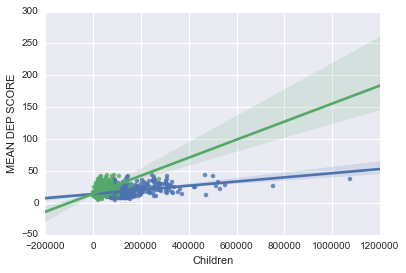

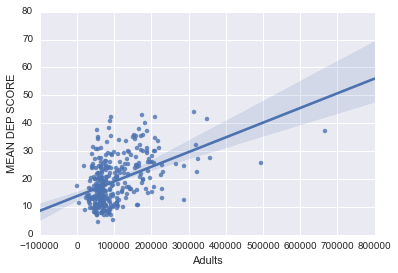

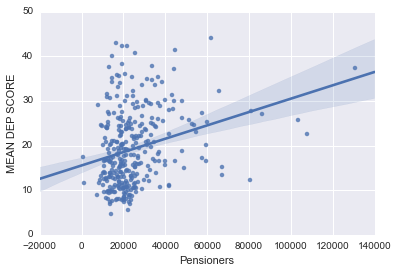

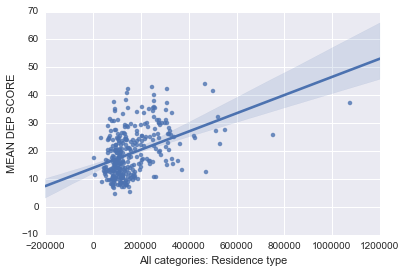

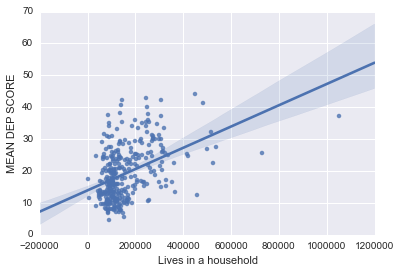

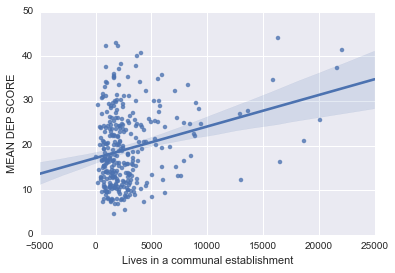

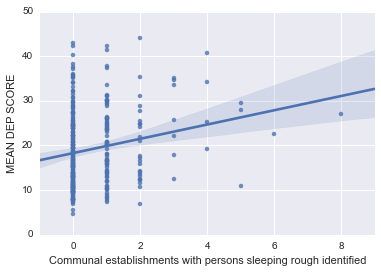

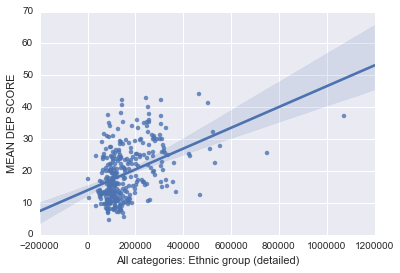

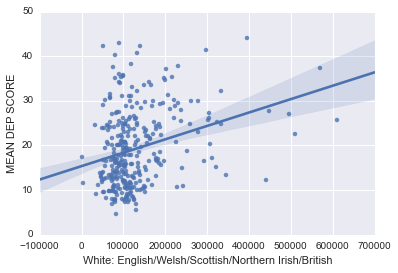

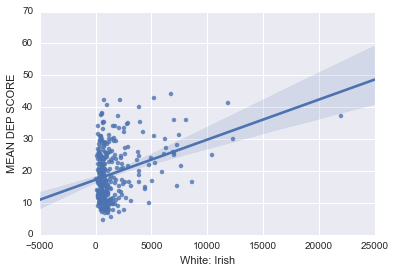

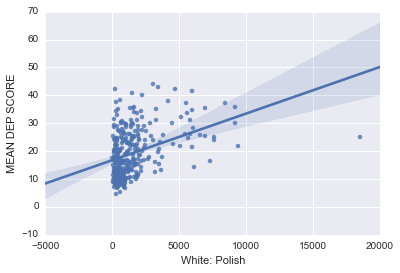

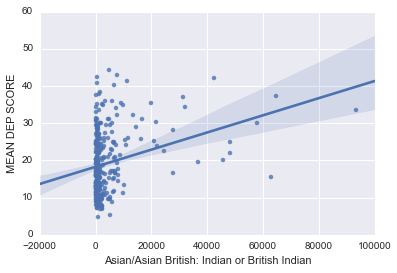

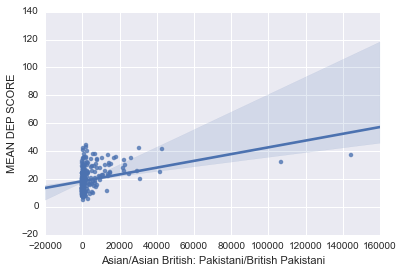

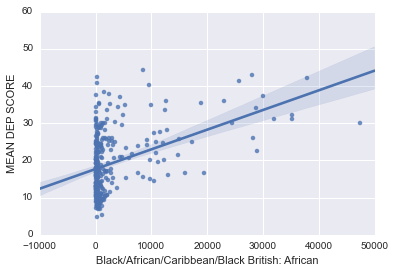

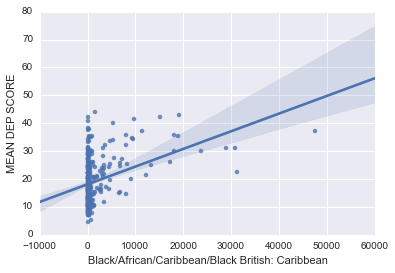

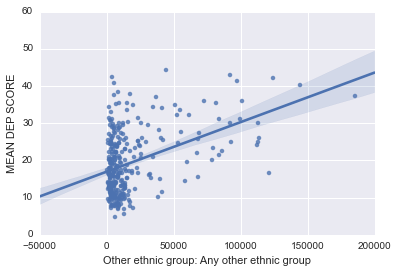

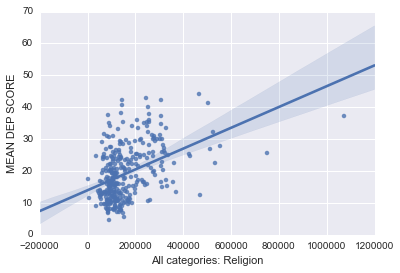

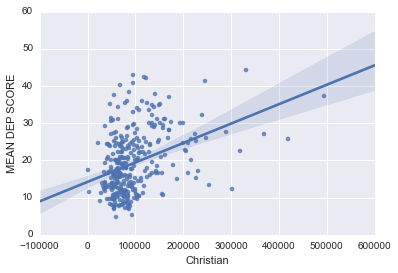

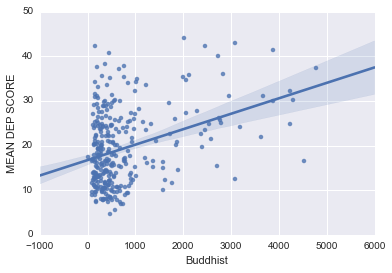

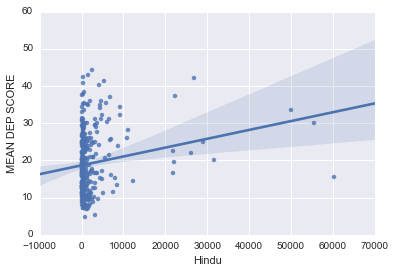

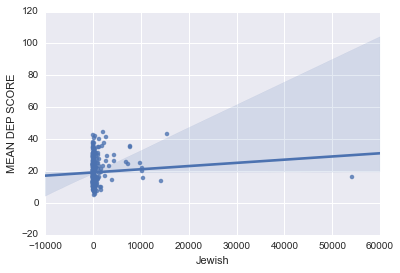

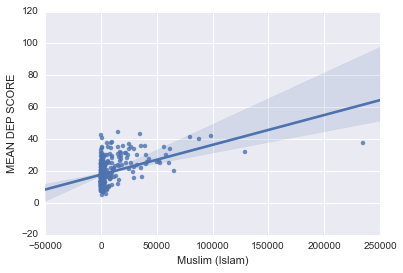

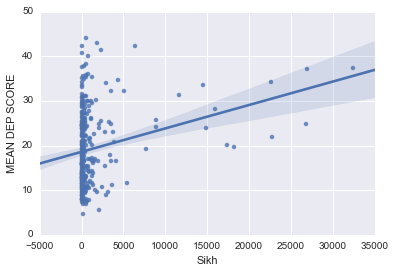

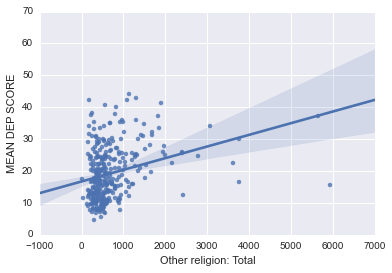

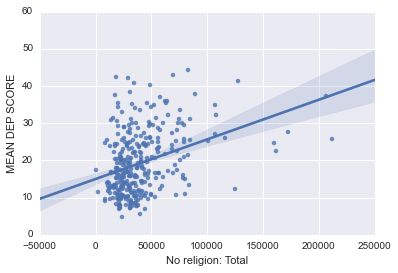

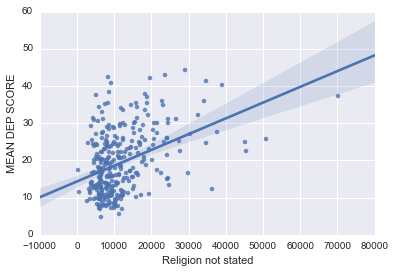

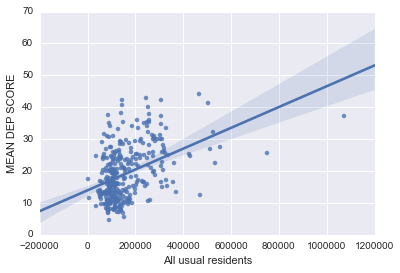

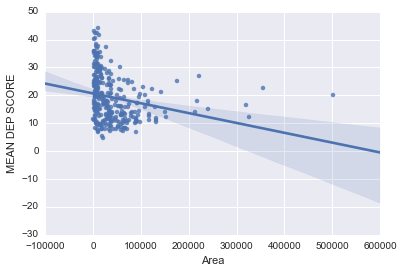

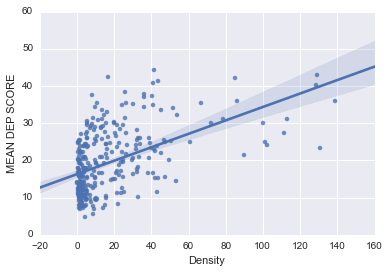

In [34]:
#REGRESSIONS PLOTTED and saved FOR EACH VARIABLE
#for item in columns2[6:]:
for i in range(len(cols2[:])):
    sns.regplot(y=final_data['MEAN DEP SCORE'],x=final_data[cols2[i]], fit_reg=True)
    plt.savefig(str(cols2[i]).replace('/','').replace(':','')+".png")
    plt.figure(i+1)
plt.show()



Cargando los datos de .csv . . .

In [35]:
#LOADS DATA FROM CSV
data = pd.read_csv("Predictors of Deprivation.csv", encoding = "ISO-8859-1", low_memory=False)
data_df = DataFrame(data)
data_df.head()

,Unnamed: 0,MEAN DEP SCORE,LA CODE,STD DEP SCORE,LAD,LAD CODE,WARD CODE,All categories: Age,Children,Adults,...,Hindu,Jewish,Muslim (Islam),Sikh,Other religion: Total,No religion: Total,Religion not stated,All usual residents,Area,Density
0,0,11.515124,00AA,6.405421,E09000001,00AA,00AAFA,7375,692,5721,...,145,166,409,18,28,2522,651,7375,290,25.5
1,1,34.094765,00AB,8.255361,E09000002,00AB,00ABFX,185911,53544,114160,...,4464,425,25520,2952,533,35106,11968,185911,3609,51.5
2,2,16.488612,00AC,8.427992,E09000003,00AC,00ACFX,356386,83073,228823,...,21924,54084,36744,1269,3764,57297,29917,356386,8674,41.1
3,3,16.520170,00AD,10.268777,E09000004,00AD,00ADGA,231997,54140,142786,...,3547,234,5645,4156,724,55995,16226,231997,6056,38.3
4,4,30.166109,00AE,11.454649,E09000005,00AE,00AEGJ,311215,70364,210212,...,55449,4357,58036,1709,3768,33054,21462,311215,4324,72.0


Llegó a ser obvio que hay un par de células que muestran basicamente la misma información; la población total en cada area ('All categories: Age' y 'All usual residents' por ejemplo). Las tiré estas columnas porque no satisfacen los supuestos de independencia de las variables que es necesario por una regresión multiple. Estoy al tanto que es posible que la religión y la etnicidad no sean verdaderamente independiente aunque la categoria de 'Other ethnic groups' contiene tantas etnicidades que creo que el supuesto no se rompe.

Después de tirar las columnas, hice una lista nueva de columnas por cada fuente de datos (hice lo mismo hace trés células . . .inútilmente); las variables explicatives en aquellas listas serán regresado a la variable de respuesta MEAN DEP SCORE . . .

In [36]:
#DROPS COLUMNS WHICH ONLY GIVE THE POPULATION INFORMATION 
#EG 'ALL USUAL RESIDENTS' GIVES THE SAME INFO AS 'ALL CATEGORIESS RELIGION'
#SPLITS THE COLUMN NAMES INTO THE ORIGINAL CATEGORIES
x_vals = data_df.drop(['MEAN DEP SCORE','All usual residents ','All categories: Religion','All categories: Ethnic group (detailed)','All categories: Residence type','All categories: Age','Unnamed: 0','LA CODE','STD DEP SCORE','LAD','LAD CODE','WARD CODE'], axis=1)
x_cols = list(x_vals.columns)
age_vals = x_cols[:3]
com_vals = x_cols[3:6]
eth_vals = x_cols[6:14]
rel_vals = x_cols[14:23]
dens_vals = x_cols[23:]

La célula abajo define una función que recibe como entradas una lista de columnas que contienen variables explicativas, el DataFrame de que vienen y la variable de respuesta.

La función da un DataFrame que contiene información sobre una regresión simple por cada variable contra la variable de respuesta. Este DataFrame contiene información sobre:
<ul>
    <li>el coeficiente de regresión (la inclinación de la línea - como cambia la variable Y por un cambio en X)</li>
    <li>el Intercepto (donde la línea de regresión cruza el axis)</li>
    <li>el RSS (como la línea cabe los datos - valores mas bajos son mejores)</li>
    <li>la Diferencia (una medida de como los valores se extienden)</li>
    <li>R-Squared (el porcentaje de la diferencia que se explica por saber las variables-X - valores mas altos son mejores.)</li>
    <li>el p-valor (ayuda determinar si la equación de la regresión esta estadisticamente significativo - valores mas bajos son mejores, menoe de 0.05 esta bastante bien).</li>
    <li>el error estandar (ayuda evaluar la precisión de una predicción).</li>
</ul>

Por cada item arriba, lo anexé en el DataFram con un '(sk)' que indica que usé Sklearn para la calculación, or '(sci)' que indica que usé SciPy para la calculación.

Las variables explicativas se agrupan en las categorías de que se cargaron porque intento escoger una variable de cada grupo para incluir en una regresión multiple.

In [37]:
#GETS THE INDIVIDUAL REGRESSION FOR EACH VARIABLE AGAINST THE MEAN DEPRIVATION SCORE
def get_regs(x_cols, x_variables, y_variable):
    """Takes a list of columns, a dataframe of x_variables and a y_variables (Series or DataFrame), and returns a DataFrame
    of the Intercept, Coerfficient, RSS and Variable for each x_variable and the y_variable. The list x_cols should be 
    the names of a subset of columns from the x_variable DataFrame.
    """
    outputlist = []
    regression_funcs = []
    for i in range(len(x_cols)):
        #CREATES SK LEARN REGRESSION MODEL
        reg_func = linear_model.LinearRegression()
        #TRAINING/TESTING SPLIT - TEST SIZE IS DEFAULT
        x_train, x_test, y_train, y_test = cross_validation.train_test_split(x_variables[x_cols[i]],y_variable, test_size = 0.25)
        #CREATES SCIPY REGRESSION MODEL FOR R, P AND STD ERR
        slope,intercept,r_val,p_val,stderr = stats.linregress(y=y_train,x=x_train)
        #ADDS THE DATA ABOUT THE REGRESSION MODELS TO A DICTIONARY
        outputlist.append({'X-Variable':str(x_cols[i]).replace("'",''),
                           'Coef(sk)':reg_func.fit(np.reshape(x_train,((len(x_train),1))), y_train).coef_[0],
                           'Intercept(sk)':reg_func.fit(np.reshape(x_train,((len(x_train),1))), y_train).intercept_,
                           'RSS(sk)':np.mean((reg_func.predict(np.reshape(x_test,((len(x_test),1))))-y_test)**2),
                           'Variance(sk)':reg_func.score(np.reshape(x_test,((len(x_test),1))), y_test),
                          'R-value(sci)':r_val,
                          'R-squared(sci)':r_val**2,
                          'P-value(sci)':p_val,
                          'Std Err(sci)':stderr})
        
        regression_funcs.append({'X-Variable':str(x_cols[i]).replace("'",''),
                                'Regression Object':reg_func})
    #OUTPUTS A DATAFRAME AND REORDERS THE VARIABLES SENSIBLY
    df = DataFrame(outputlist)
    df = df[['X-Variable','Intercept(sk)','Coef(sk)',  'RSS(sk)', 'Variance(sk)','R-value(sci)','R-squared(sci)','P-value(sci)','Std Err(sci)' ]]
    return df,regression_funcs

Esta célula aplica la función arriba a las listas de variables.

In [1]:
#GETS REGRESSIONS ON EACH VARIABLE AGAINST THE MEAN DEPRIVATION SCORE
age_reg_df,age_regs = get_regs(age_vals,x_vals,data_df['MEAN DEP SCORE'])
com_reg_df,com_regs = get_regs(com_vals,x_vals,data_df['MEAN DEP SCORE'])
eth_reg_df,eth_regs = get_regs(eth_vals,x_vals,data_df['MEAN DEP SCORE'])
rel_reg_df,rel_regs = get_regs(rel_vals,x_vals,data_df['MEAN DEP SCORE'])
dens_reg_df,dens_regs = get_regs(dens_vals,x_vals,data_df['MEAN DEP SCORE'])

# now to decide which variable from each group to include in the final multiple regression          

NameError: name 'get_regs' is not defined

Este DataFrame muestra los valores de la regresión por las variables de densidad de población. Decidí tomar 'Population Density' así que tiene un R^2 mas alto, y un p-valor y RSS mas bajo que 'Area'.

In [39]:
dens_reg_df #take Density - high R^2, lower p-value, smaller RSS

,X-Variable,Intercept(sk),Coef(sk),RSS(sk),Variance(sk),R-value(sci),R-squared(sci),P-value(sci),Std Err(sci)
0,Area,20.364735,-0.000034,69.332510,0.055812,-0.218199,0.047611,5.984320e-04,0.000010
1,Density,16.222283,0.178736,61.649141,0.276955,0.493837,0.243875,2.091625e-16,0.020231


Este DataFrame muestra los valores de la regresión de las variables de religión. Decidí tomar 'No Religion:Total' y 'Religion not stated' así que tienen R^2 valores y p-valores razonables y un RSS pequeño. Hay un caso de incluir casi todas de las otras variables, pero querría limitar la cantidad que considero para inclusión en la regresión multiple. Espero que pruebes este análisis con combinaciones da variables diferentes!

In [40]:
rel_reg_df # take no religion: total and religion not stated - lowest RSS, reasonable R^2, lowest p-value

,X-Variable,Intercept(sk),Coef(sk),RSS(sk),Variance(sk),R-value(sci),R-squared(sci),P-value(sci),Std Err(sci)
0,Christian,14.346330,0.000051,72.059505,0.102854,0.394980,0.156009,1.551414e-10,0.000008
1,Buddhist,15.987272,0.004164,59.519725,0.058685,0.348671,0.121572,2.205961e-08,0.000720
2,Hindu,19.054903,0.000199,51.209229,0.057785,0.150973,0.022793,1.828966e-02,0.000084
3,Jewish,18.935744,0.000127,71.406320,0.001787,0.058712,0.003447,3.611468e-01,0.000139
4,Muslim (Islam),17.042289,0.000290,83.951083,-0.082738,0.470447,0.221320,7.681220e-15,0.000035
5,Sikh,19.050486,0.000481,70.367367,-0.009192,0.255785,0.065426,5.290271e-05,0.000117
6,Other religion: Total,17.283141,0.003222,53.723960,0.108819,0.267568,0.071593,2.279769e-05,0.000746
7,No religion: Total,14.871529,0.000109,71.945679,0.114103,0.354501,0.125671,1.233217e-08,0.000019
8,Religion not stated,14.504361,0.000444,42.887706,0.121009,0.406599,0.165322,3.941129e-11,0.000064


Este DataFrame muestra los valores de la regresión por las variables de la etnicidad. Decidí tomar 'Black/African/Caribbean/Black British: African' y 'Other ethnic group: Any other ethnic group' así que los dos tienen valores altos de R^2, p-valores bajos, y (en el caso de 'Black/African/Caribbean/Black British: African') un RSS pequeño. Otra vez, podría haber escogido más, u otro variables para incluir en la regresión multiple.

In [41]:
eth_reg_df # take African and other ethnic group - lowest RSS, highest r^2 and lowest p-value

,X-Variable,Intercept(sk),Coef(sk),RSS(sk),Variance(sk),R-value(sci),R-squared(sci),P-value(sci),Std Err(sci)
0,White: English/Welsh/Scottish/Northern Irish/B...,15.347880,0.000031,61.234447,0.097515,0.282606,0.079866,7.342738e-06,0.000007
1,White: Irish,17.187757,0.001217,71.437101,0.098294,0.329031,0.108261,1.437104e-07,0.000224
2,White: Polish,16.507810,0.002110,65.887255,0.058538,0.398824,0.159061,9.916653e-11,0.000312
3,Asian/Asian British: Indian or British Indian,17.731878,0.000225,79.777338,-0.016017,0.302906,0.091752,1.428503e-06,0.000046
4,Asian/Asian British: Pakistani/British Pakistani,18.672440,0.000234,55.443517,0.021578,0.350451,0.122816,1.849438e-08,0.000040
5,Black/African/Caribbean/Black British: African,17.800460,0.000533,62.589540,0.214160,0.408438,0.166821,3.157152e-11,0.000077
6,Black/African/Caribbean/Black British: Caribbean,18.172565,0.000627,54.076499,0.127721,0.380181,0.144537,8.240526e-10,0.000098
7,Other ethnic group: Any other ethnic group,16.572930,0.000153,61.735524,0.104961,0.441273,0.194722,4.756173e-13,0.000020


Este DataFrame muestra los valores de la regresión por las variables de 'Communal Living'. Decidí tomar 'Lives in a household' así que tiene un R^2 mas alto, y un p-value y RSS mas pequeño que las otras. Es posible que los valores sean así gracias a que la magnitud de los números que se recordaron por 'Lives in a communal establishment' y 'Communal establishments with persons sleeping rough' fue mas bajo que los de 'Lives in a household'.

In [42]:
com_reg_df # take lives in a household - lowest RSS, p-value and highest r^2. 

,X-Variable,Intercept(sk),Coef(sk),RSS(sk),Variance(sk),R-value(sci),R-squared(sci),P-value(sci),Std Err(sci)
0,Lives in a household,13.156717,0.000037,60.686792,0.177968,0.428568,0.183671,2.544955e-12,0.000005
1,Lives in a communal establishment,17.486256,0.000656,73.405096,0.073749,0.257198,0.066151,4.792102e-05,0.000158
2,Communal establishments with persons sleeping ...,18.586784,1.712720,65.731140,-0.031709,0.225864,0.051015,3.764627e-04,0.474855


Este DataFrame muestra los valores de la regresión por las variables de 'Age'. Decidí tomar 'Children' como la única variable de esta lista porque tiene el R^2 mas alto y un p-value y RSS bajo.

In [43]:
age_reg_df # take children, low RSS and p-value, highest R^2

,X-Variable,Intercept(sk),Coef(sk),RSS(sk),Variance(sk),R-value(sci),R-squared(sci),P-value(sci),Std Err(sci)
0,Children,14.157832,0.000152,53.832585,0.227314,0.407424,0.165994,3.568239e-11,0.000022
1,Adults,14.138562,0.000050,48.294427,0.245643,0.437462,0.191373,7.924612e-13,0.000007
2,Pensioners,14.931408,0.000178,66.742276,-0.055553,0.325079,0.105677,2.062952e-07,0.000033


Esta célula toma las variables escogidas de cata categoría y las guarda en una lista para que se puedan entrar en una regresión multiple.

In [44]:
#TAKES THE INDIVIDUAL COLUMNS WHICH I DECIDED UPON AND ADDS THEM TO THE LIST OF POTENTIAL VARIABLES TO BE INCLUDED IN A
#MULTIPLE LINEAR REGRESSION
multimodel_columns = [age_vals[0],com_vals[0],eth_vals[5],eth_vals[7],rel_vals[7], rel_vals[8],dens_vals[1]]
multimodel_columns

['Children',
 'Lives in a household',
 'Black/African/Caribbean/Black British: African',
 'Other ethnic group: Any other ethnic group',
 'No religion: Total',
 'Religion not stated',
 'Density']

Para preparar por la regresión multiple, hice una función que crea una matriz de las combinaciones distintas de las variables.Por ejemplo, con 3 variables habría 2^3 = 8 combinaciones posibles:
<ol>
<li>[0][0][0]</li>
<li>[1][0][0]</li>
<li>[1][1][0]</li>
<li>[1][0][1]</li>
<li>[1][1][1]</li>
<li>[0][1][0]</li>
<li>[0][1][1]</li>
<li>[0][0][1]</li>
</ol>

El diagrama arriba muestra todas las combinaciones de tres variables diferentes; si hay un '1' en la caja, aquella variables se incluriría en el modelo.

Si ignoro la combinación que tiene 0 variables, tengo que probar (2^7)-1 = 127  combinaciones distintas. Si introduzco otra variable, habrá 255 combinaciones. Espero que veas porque querría restringir la cantidad de variables.

In [45]:
#makes a matrix of the possible combinations OF ALL THE POTENTIAL REGRESSION VARIABLES, AND SAVES AS A DATAFRAME
# BE CAREFUL, THIS GIVES a little (2^^n)-1 COMBINATIONS

def create_dataframes_for_multi_linear_model(inputlist, inputdata):
    '''Takes an inputlist of column names which should be a subset of columns in inputdata, calculates every possible combination
    of the columns and returns a list of dataframes, each containing a different combination of the input data'''
    
    output_dataframes = []
    #this makes the matrix of 1s and 0s and maps the column list to it, saving a dataframe of that particular column where a
    #1 would be in the matrix
    #ACTUALLY MAKES THE MATRIX
    template = [list(i) for i in itertools.product([0,1], repeat = len(inputlist)) if sum(i) >0]
    check_template = copy.deepcopy(template)

    #ASSIGNS THE DATAFRAME COLUMNS TO EACH '1'
    for j in range(len(template)):
        for k in range(len(template[j])):
            if template[j][k] == 1:
                template[j][k] = DataFrame(inputdata[inputlist[k]])
                
    # takes the matrix of dataframes and concats them together into a single dataframe (where there is more than 1)
    # I should now be able to perform a linear regression on every combination of dataframe
    for i in range(len(template)):
        j=0
        temp_df = DataFrame()
        while j < len(template[i]):
            if isinstance(template[i][j], pd.DataFrame):
                if len(temp_df)==0:
                    temp_df = DataFrame(template[i][j])
                else:
                    temp_df = DataFrame(pd.concat([temp_df,template[i][j]], axis=1))
            j+=1
        output_dataframes.append(temp_df)
    
    return output_dataframes


Esta célula aplica la función arriba a la lista de columnas:

In [46]:
#ALL POSSIBLE COMBINATIONS OF VARIABLES
multi_dataframes = create_dataframes_for_multi_linear_model(multimodel_columns, data_df)    

Esta función hace una regresión multiple a cada combinación de las variables que calculé en la función arriba. Si no lees el código, quiero que sepas que fue muy difícil.

In [47]:
def multiple_linear_regression(xvar_combinations, y_variable):
    '''Does a multiple regression on each item in the list of xvar_combinations. 
    This should be the output from create_dataframes_for_multi_linear_model.
    Saves the information about each multiple regression to a DataFrame to allow the models to be compared.
    Outputs a DataFrame containing the Coefficients, Intercept, RSS, Variance, P-Value, R^2 and SE, 
    as well as a dictionary of the summaries from the statsmodel OLS function.'''
    regression_outputs = []
    regression_summaries= []
    
    for i in range(len(xvar_combinations)):
        #SKLEARN MODEL - DONT NEED TO DO A TRAIN-TEST SPLIT AS I'M NOT TRYING TO MAKE A PREDICTIVE MODEL
        reg_func = linear_model.LinearRegression()
        
        
        #STATSMODELS MODEL - NEED FOR R-VALUE, P-VALUE ETC
        #USEFUL PARAMETERS FROm THE STATSMODELS.OLS - http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.RegressionResults.html
        #MAY NOT WANT TO ADD A CONSTANT IF REGRESSION SHOULD BE CONSTRAINED THROUGH THE ORIGIN
        xvariables = sm.add_constant(xvar_combinations[i], prepend=False)
        model = sm.OLS(y_variable,xvariables)
        results = model.fit()
        #GETS THE NAMES OF THE VARIABLES IN THE MODEL
        x_variable_names_start = str(xvar_combinations[i].columns).find('[')
        x_variable_names_end = str(xvar_combinations[i].columns).find(']')
        x_variable_names = str(xvar_combinations[i].columns)[x_variable_names_start+1:x_variable_names_end].replace("'",'')
        
        regression_outputs.append({'X-Variables':x_variable_names,
                   'Coef(sk)':reg_func.fit(xvariables, y_variable).coef_,
                   'Intercept(sk)':reg_func.fit(xvariables, y_variable).intercept_,
                   'RSS(sm)':np.mean((results.resid**2)),
                          'P-Value(sm)':results.f_pvalue,
                          'R-Squared(sm)':results.rsquared,
                                  'Std Err(sm)':results.scale**0.5,
                                  'ID':i})
        regression_summaries.append({'X-Variables':x_variable_names,'Summary':results.summary(),'ID':i})
    #OUTPUTS DATAFRAME AND ORDER COLUMNS SENSIBLY
    df = DataFrame(regression_outputs)
    df = df[['X-Variables','Intercept(sk)','Coef(sk)',  'RSS(sm)', 'R-Squared(sm)','P-Value(sm)','Std Err(sm)','ID' ]]
        
    return df, regression_summaries
    

Esta célula aplica la función de regresión multiple a las combinaciones de los DataFrames:

In [50]:
multiple_linear_models,summaries = multiple_linear_regression(multi_dataframes,data_df['MEAN DEP SCORE'])

Me costaría mucho examinar las 127 combinaciones de las variables; gracias a eso inventé un método crudo para ayudarme determinar cual combinación de las variables considero los candidatos adecuados por una regresión multiple.

Creé 4 copias de los datos de la regresión y las ordené según los resultados de las medidas 'P-value(sm)', 'R-Squared(sm)', 'RSS(sm)' y 'Std Err(sm)'. Luego recombiné los DataFrames y sumé los rangos. Esta técnica me permitió tirar los modelos que no funcionaron bién y enfocarme en considerar los 5 modelos a la cabeza de la lista.

In [51]:
#CREATES SEPARATE DATAFRAMES, EACH SORTED BY A DIFFERENT MEASURE OF 'GOODNESS' OF THE MODEL
by_p = multiple_linear_models.sort(['P-Value(sm)'], ascending=True)
by_r = multiple_linear_models.sort(['R-Squared(sm)'],ascending=False)
by_RSS = multiple_linear_models.sort(['RSS(sm)'],ascending=True)
by_se = multiple_linear_models.sort(['Std Err(sm)'], ascending=True)

#RANKS THE MODELS BY HOW WELL THEY PERFORM IN EACH METRIC
by_p['rank']=by_p.reset_index().index.values
by_r['rank']=by_r.reset_index().index.values
by_RSS['rank']=by_RSS.reset_index().index.values
by_se['rank']=by_se.reset_index().index.values

In [52]:
#KEEPS ONLY THE RANK AND X-VARIABLES COLUMN
def get_ranks(dataframe):
    output = dataframe.loc[:,['X-Variables','rank']]
    output.rename(columns={'rank':'rank'}, inplace=True)
    return output

ranked_by_p = get_ranks(by_p)
ranked_by_r = get_ranks(by_r)
ranked_by_RSS = get_ranks(by_RSS)
ranked_by_se = get_ranks(by_se)

In [53]:
#STICKS THE MODELS TOGETHER, SUMMING THE RANKS OF EACH, FINALLY MERGING WITH THE FULL INFO ABOUT THE MODELS AND SORTING
#TO REVEAL WHICH ARE THE BEST CANDIDATES FOR PREDICTING DEPRIVATION
final_multimodels = pd.concat([ranked_by_r,ranked_by_p, ranked_by_RSS, ranked_by_se]).groupby(['X-Variables'], as_index=False)['rank'].sum()
final_model_and_data = final_multimodels.merge(multiple_linear_models,how='left',on='X-Variables')


final_model_and_data.rename(columns={'rank':'Sum of Rank'},inplace=True)
final_model_and_data.sort('Sum of Rank')



,X-Variables,Sum of Rank,Intercept(sk),Coef(sk),RSS(sm),R-Squared(sm),P-Value(sm),Std Err(sm),ID
87,"Lives in a household,\n Black/African/Ca...",7,12.210549,"[8.30532615656e-05, 0.000188751423961, -0.0001...",41.987483,0.409067,8.023450e-34,6.550484,62
41,"Children, Lives in a household,\n Black/...",17,12.234387,"[0.000109624833768, 5.40861933451e-05, 0.00017...",41.862720,0.410823,3.211866e-33,6.551021,126
56,"Children, Lives in a household,\n Other ...",17,12.144967,"[0.000134059573103, 4.9897005847e-05, -0.00015...",42.219062,0.405808,1.898987e-33,6.568523,110
108,"Lives in a household, Other ethnic group: Any ...",20,12.106615,"[8.55408862423e-05, -0.000134155979803, -7.573...",42.408945,0.403135,5.519395e-34,6.572984,46
28,"Children, Black/African/Caribbean/Black Britis...",21,12.395731,"[0.000286055396495, 0.000160819423157, -0.0002...",42.237636,0.405546,2.034417e-33,6.569968,94
26,"Children, Black/African/Caribbean/Black Britis...",24,12.261860,"[0.000268253747312, 0.000199268789424, -0.0002...",42.409197,0.403132,5.524580e-34,6.573003,92
39,"Children, Lives in a household,\n Black/...",25,12.120359,"[0.000163508727568, 2.99890064633e-05, 0.00022...",42.268010,0.405119,2.276844e-33,6.572330,124
74,"Children, Other ethnic group: Any other ethnic...",30,12.301525,"[0.000296010110107, -0.00016894797577, -4.7616...",42.540177,0.401288,8.987470e-34,6.583146,78
43,"Children, Lives in a household,\n Black/...",34,12.332372,"[0.000152718314797, 3.27369518917e-05, 0.00013...",42.393435,0.403354,3.621134e-33,6.582074,122
30,"Children, Black/African/Caribbean/Black Britis...",34,12.423524,"[0.00026454211561, 0.000129254275418, -0.00017...",42.547776,0.401182,9.244410e-34,6.583734,90


El modelo con el resultado de rango mas bajo parece ser razonable. La columna Coef(sk) muestra una lista de valores, cada valor coresponde a cada X-Variable.

In [54]:
a=final_model_and_data.loc[[87]]
a

,X-Variables,Sum of Rank,Intercept(sk),Coef(sk),RSS(sm),R-Squared(sm),P-Value(sm),Std Err(sm),ID
87,"Lives in a household,\n Black/African/Ca...",7,12.210549,"[8.30532615656e-05, 0.000188751423961, -0.0001...",41.987483,0.409067,8.023450e-34,6.550484,62


Aquí está el sumario de la regresión del mejor modelo (según mis métodos crudos!); de las variables, parece que la densidad de la población tiene el efecto mas grande en el MEAN DEP SCORE de una area, con un coeficiente de 0.2641. El R^2 del modelo es bastante bajo, pero lo acepto poque los datos son desordenados.

In [55]:
summaries[62]['Summary']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         MEAN DEP SCORE   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     36.80
Date:                Tue, 26 Jan 2016   Prob (F-statistic):           8.02e-34
Time:                        21:44:19   Log-Likelihood:                -1071.8
No. Observations:                 326   AIC:                             2158.
Df Residuals:                     319   BIC:                             2184.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------------------
Lives in a household                            8.305e-05   1.19e-05      6.975      0.000      5.96e-05     0.000
Black/African/Caribbean/Black British: African     0.0002      0.000      1.789      0.074     -1.88e-05     0.000
Other ethnic group: Any other ethnic group        -0.0002   4.16e-05     -4.303      0.000        -0.000 -9.71e-05
No religion: Total                             -8.921e-05   3.99e-05     -2.235      0.026        -0.000 -1.07e-05
Religion not stated                               -0.0004      0.000     -2.100      0.037        -0.001  -2.4e-05
Density                                            0.2641      0.028      9.453      0.000         0.209     0.319
const                                             12.2105      0.736     16.594      0.000        10.763    13.658
==============================================================================
Omnibus:                       15.877   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.394
Skew:                           0.561   Prob(JB):                     0.000167
Kurtosis:                       2.854   Cond. No.                     4.08e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#Gracias por leer! Si tiene algunas preguntas, comentarios o recomendaciones, díme por favor! Si le gustaría continuar o expandir el análisis se puede encontrarlo en mi cuenta de <a href="https://github.com/rytchbass/ONS-Geo-Codes">GitHub</a>.